In [14]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from IPython import display
%matplotlib inline

In [15]:
# helper plotting functions
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid

In [13]:
def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig



In [4]:
# init environment, sab = Sutton and Barto impementation
env = gym.make("Blackjack-v1", 
               natural=True, 
               sab=True, 
               render_mode='rgb_array'
              )

In [5]:
done = False
state, info = env.reset()
print(state, info)

(20, 9, False) {}


### What is state?

State is a representation, here of a tuple.<br>
state[0] is the sum value of my cards.<br>
state[1] is the value of the visible dealer card.<br>
state[2] boolean of whether the user holds a 'usable' ace.<br>
<br>
<br>

In [6]:
print("env.action_space: ", env.action_space)
sampled_actions = []
for i in range(10):
    sampled_actions.append(env.action_space.sample())
print("sampled_actions: ", sampled_actions)
num_actions = env.action_space.n
print("Total number of actions: ", num_actions)

env.action_space:  Discrete(2)
sampled_actions:  [1, 1, 1, 0, 0, 0, 0, 1, 1, 1]
Total number of actions:  2


<br>
<br>

### What are our actions?
env.action_space: gives us a 2 discrete actions {0,1} ==> {hold, hit} <br>
env.action_space.sample() - samples uniformly at random

In [7]:
# what does acting in the environment look like?
next_state, reward, terminated, truncated, info = env.step(0)
print("next_state: ", next_state)
print("reward: ", reward)
print("terminated: ", terminated)
print("truncated: ", truncated)
print("info: ", info)

next_state:  (20, 9, False)
reward:  1.0
terminated:  True
truncated:  False
info:  {}




### The transition:

#### The environment transitions to a new state, a reward is emitted, and some other information:
<br>
terminated: boolean (is the episode over)
truncated: boolean (is the episode over - depending on environments we may 'truncate' the episode, though it still has not ended yet)


### The agent:

#### This is where we will implement Q-learning, the Q-table, and Epsilon greedy action selection


In [9]:
class Agent:
    def __init__(
        self,
        env,
        learning_rate: float = 0.1,
        init_epsilon: float = 1.0,
        final_epsilon: float = 0.1,
        gamma: float = 0.99,
        num_training_epochs: int = 500,
        num_episodes_per_epoch: int = 2000
    ):
        
        self.env = env
        self.q_values = defaultdict(lambda: -1.*np.ones(env.action_space.n))
        #self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
        self.lr = learning_rate
        self.epsilon = init_epsilon
        self.epsilon_decay = init_epsilon / (num_training_epochs * num_episodes_per_epoch / 2)
        self.final_epsilon = final_epsilon
        self.gamma = gamma
        
        
        
        
        
        # trainin/eval details
        self.num_training_epochs = num_training_epochs
        self.num_episodes_per_epoch = num_episodes_per_epoch
        
        self.is_training = True
        # by episode
        self.training_td_error = []
        self.training_rewards = []
        self.validation_rewards = []
        
        # by epoch
        self.training_epoch_mean_td_error = []
        self.training_epoch_mean_rewards = []
        self.validation_epoch_mean_rewards = []
        
        
        
    def set_validation(self):
        self.is_training = False
        return
    
    
    def set_training(self):
        self.is_training = True
        return
        
        
    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon-self.epsilon_decay)
        return
        
        
    def reset_epoch(self):
        state, _ = self.env.reset()
        return state
    
    
    
        
    def get_action(self, state: tuple[int, int, bool]) -> int:
        # GLIE (epsilon greedy)
        if self.is_training:
            # epsilon greedy
            if np.random.random() < self.epsilon:
                return env.action_space.sample()
            else:
                return int(np.argmax(self.q_values[state]))
            
        # no need for duplication, but just to demonstrate logically/clearly
        else:
            # act greedy (follow policy)
            return int(np.argmax(self.q_values[state]))
        
    
    
    
    def q_learning_update(self, 
                          state: tuple[int, int, bool],
                          action: int,
                          reward: float,
                          is_done: bool,
                          next_state: tuple[int, int, bool]
                         ):
        # V(s') = 0 if is_done, else ....
        next_state_value = (not is_done) * np.max(self.q_values[next_state])
        
        # temporal difference
        td_error = (reward + self.gamma*next_state_value) - (self.q_values[state][action])
        
        # do update Q(s, t) <-- Q(s,t) + alpha{r + V(s') - Q(s,a)}
        #                   <-- (1-alpha)*Q(s,t) + alpha{r + V(s')}
        self.q_values[state][action] =  self.q_values[state][action] + self.lr*td_error
        
        self.training_td_error.append(td_error)
        
        return
    
    
    
    def do_episode(self):
        state = self.reset_epoch()
        done = False
        total_rewards = 0.
        
        
        while not done:
            action = self.get_action(state)
            next_state, r, terminated, truncated, _ = env.step(action)
            
            total_rewards += r
            
            # update if we are training
            if self.is_training:
                self.q_learning_update(state, action, r, terminated, next_state)
 
            # update state
            done = terminated or truncated
            state = next_state
        
        
        if self.is_training:
            # update rewards
            self.training_rewards.append(total_rewards)
            # decay exploration
            self.decay_epsilon()
        else:
            self.validation_rewards.append(total_rewards)
        
        return
        

    
    

    
    def do_epoch(self):
        for episode in range(self.num_episodes_per_epoch):
            self.do_episode()
        # epoch complete - update epoch stats
        if self.is_training:
            # update epoch stats
            mean_td_error = np.mean(self.training_td_error)
            self.training_epoch_mean_td_error.append(mean_td_error)
            mean_rewards = np.mean(self.training_rewards)
            self.training_epoch_mean_rewards.append(mean_rewards)
            
            # reset episodic stats
            self.training_td_error = []
            self.training_rewards = []
            
        else:
            mean_rewards = np.mean(self.validation_rewards)
            self.validation_epoch_mean_rewards.append(mean_rewards)
            self.validation_rewards = []
        
        
    
    def do_rl(self):
        # state values & policy with usable ace (ace counts as 11)
        value_grid, policy_grid = create_grids(self, usable_ace=True)
        fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
        plt.show()
        plt.close()

        # state values & policy without usable ace (ace counts as 1)
        value_grid, policy_grid = create_grids(self, usable_ace=False)
        fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
        plt.show()

        for epoch in range(self.num_training_epochs):
            # do eval
            self.set_validation()
            self.do_epoch()
            
            # do training
            self.set_training()
            self.do_epoch()
        
            if (epoch+1)%50 == 0:
                # plot
                fig, axs = plt.subplots(ncols=3, figsize=(12,5))
                
                axs[0].set_title("Training TD Error")
                axs[0].plot(self.training_epoch_mean_td_error)
                
                axs[1].set_title("Training Rewards\nMean over Epoch")
                axs[1].plot(self.training_epoch_mean_rewards)
                
                axs[2].set_title("Validation Rewards\nMean over Epoch")
                axs[2].plot(self.validation_epoch_mean_rewards)
                
                plt.tight_layout()
                plt.show()
                
                # state values & policy with usable ace (ace counts as 11)
                value_grid, policy_grid = create_grids(self, usable_ace=True)
                fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
                plt.show()
                plt.close()
                
                # state values & policy without usable ace (ace counts as 1)
                value_grid, policy_grid = create_grids(self, usable_ace=False)
                fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
                plt.show()

                if (epoch+1) < self.num_training_epochs:
                    display.display(plt.gcf())
                    display.clear_output(wait=True)
                else:
                    fig, axs = plt.subplots(ncols=3, figsize=(12,5))
                
                    axs[0].set_title("Training TD Error")
                    axs[0].plot(self.training_epoch_mean_td_error)

                    axs[1].set_title("Training Rewards\nMean over Epoch")
                    axs[1].plot(self.training_epoch_mean_rewards)

                    axs[2].set_title("Validation Rewards\nMean over Epoch")
                    axs[2].plot(self.validation_epoch_mean_rewards)

                    plt.tight_layout()
                    plt.show()

In [10]:
agent = Agent(env)

<Figure size 640x480 with 0 Axes>

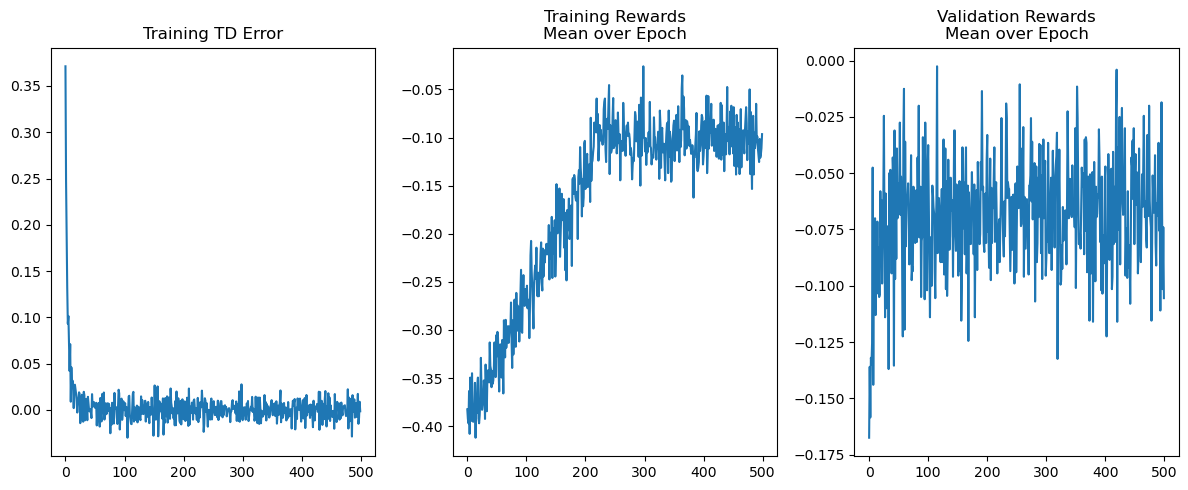

In [11]:
agent.do_rl()

In [ ]:
# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()
plt.close()

# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

In [ ]:
agent.q_values

In [ ]:
agent.epsilon

In [ ]:
x =env.render()

In [ ]:
plt.imshow(x, interpolation='nearest')